## 获取日K数据

In [1]:
from utils import get_daily_data

daily_pd, adjustment_pd = get_daily_data("002385")
daily_pd.sort_values(by="datetime",inplace=True)
daily_pd.tail()

/var/folders/cz/lx1g11xn1pzfdkhxsm2k_2g40000gn/T/ipykernel_86787/1743636007.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_pd.sort_values(by="datetime",inplace=True)


,timestamp,datetime,symbol,name,open,high,low,close,preClose,volume,amount,suspendFlag
977190,1734537600000,2024-12-19 00:00:00,002385.SZ,大北农,4.45,4.46,4.38,4.44,4.46,519035,229142441.0,0
977191,1734624000000,2024-12-20 00:00:00,002385.SZ,大北农,4.43,4.47,4.40,4.42,4.44,454148,200865845.0,0
977192,1734883200000,2024-12-23 00:00:00,002385.SZ,大北农,4.42,4.43,4.31,4.31,4.42,537942,234249708.0,0
1424717,1734969600000,2024-12-24 00:00:00,002385.SZ,大北农,4.31,4.36,4.31,4.35,4.31,336052,145792725.0,0
5223058,1735056000000,2024-12-25 00:00:00,002385.SZ,大北农,4.35,4.36,4.25,4.29,4.35,368029,157594515.0,0


## 获取前复权数据

In [2]:
from utils import get_forward_data
data_pd = get_forward_data("002385")

data_pd.tail(3)

,datetime,symbol,name,open,high,low,close,volume,amount,suspendFlag
235,2024-12-23 00:00:00,002385.SZ,大北农,4.42,4.43,4.31,4.31,537942,234249708.0,0
236,2024-12-24 00:00:00,002385.SZ,大北农,4.31,4.36,4.31,4.35,336052,145792725.0,0
964,2024-12-25 00:00:00,002385.SZ,大北农,4.35,4.36,4.25,4.29,368029,157594515.0,0


## 计算指标

计算指标放在`indicator`目录下

In [3]:
from utils import get_forward_data
from indicator import KDJ

data_pd = get_forward_data("002385")

# 删除停牌数据
data_pd = data_pd[data_pd['suspendFlag'] == 0]
data_pd.drop(columns='suspendFlag', inplace=True)

data_pd['kdj_k'], data_pd['kdj_d'], data_pd['kdj_j'] = KDJ(data_pd.close,data_pd.high, data_pd.low)

data_pd.tail(3)

,datetime,symbol,name,open,high,low,close,volume,amount,kdj_k,kdj_d,kdj_j
235,2024-12-23 00:00:00,002385.SZ,大北农,4.42,4.43,4.31,4.31,537942,234249708.0,15.250921,31.742700,-17.732637
236,2024-12-24 00:00:00,002385.SZ,大北农,4.31,4.36,4.31,4.35,336052,145792725.0,12.888369,25.457923,-12.250739
964,2024-12-25 00:00:00,002385.SZ,大北农,4.35,4.36,4.25,4.29,368029,157594515.0,11.061382,20.659076,-8.134006


## 回测

In [1]:
from utils import get_forward_data
from indicator import MACD, KDJ
import pandas as pd


data_pd = get_forward_data("002385")

# 删除停牌数据
data_pd = data_pd[data_pd['suspendFlag'] == 0]
data_pd.drop(columns='suspendFlag', inplace=True)

data_pd['kdj_k'], data_pd['kdj_d'], data_pd['kdj_j'] = KDJ(data_pd.close,data_pd.high, data_pd.low)

data_pd.tail(3)

,datetime,symbol,name,open,high,low,close,volume,amount,kdj_k,kdj_d,kdj_j
235,2024-12-23 00:00:00,002385.SZ,大北农,4.42,4.43,4.31,4.31,537942,234249708.0,15.250921,31.742700,-17.732637
236,2024-12-24 00:00:00,002385.SZ,大北农,4.31,4.36,4.31,4.35,336052,145792725.0,12.888369,25.457923,-12.250739
964,2024-12-25 00:00:00,002385.SZ,大北农,4.35,4.36,4.25,4.29,368029,157594515.0,11.061382,20.659076,-8.134006


### 使用pybroker进行回测

[文档](https://www.pybroker.com/zh-cn/latest/install.html)

In [2]:
import pybroker
from pybroker import Strategy,StrategyConfig

In [3]:
data_pd['date'] = pd.to_datetime(data_pd['datetime'],format='ISO8601')

# 注册指标到pybroker
pybroker.register_columns(["kdj_k","kdj_d","kdj_j"])

# 初始化资金:50000元
config = StrategyConfig(initial_cash=50000)

strategy = Strategy(data_pd, '4/1/2021', '09/12/2024',config=config)

#### 定义策略函数

In [5]:
def kdj_over_boughtsold_strategy(ctx):
    """策略:kdj超买超卖
    当%K值大于80时，市场可能处于超买状态；当%K值小于20时，市场可能处于超卖状态。
    
    该策略缺点：k值可能很长时间没有超过80,导致持仓太久，硬扛亏损
    """
    if ctx.bars < 20:
        return
    
    pos = ctx.long_pos()
    k = ctx.kdj_k

    # 超买超卖信号
    overbought = k[-1] > 80
    oversold = k[-1] < 20

    # k 值大于80 抛空
    if pos and overbought :
        ctx.sell_shares = pos.shares
    # k值小于20 做多两成仓位
    elif oversold:
        ctx.buy_shares = ctx.calc_target_shares(0.2)

In [6]:
# 注册策略到pybroker
strategy.add_execution(kdj_over_boughtsold_strategy, ['002385.SZ'])

In [7]:
# 回测
result = strategy.backtest()

Backtesting: 2021-04-01 00:00:00 to 2024-09-12 00:00:00

Test split: 2021-04-01 00:00:00 to 2024-09-12 00:00:00


  0% (0 of 840) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
 58% (491 of 840) |############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (840 of 840) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Finished backtest: 0:00:01


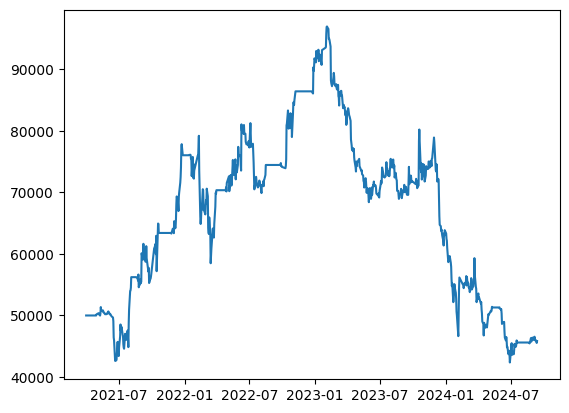

In [8]:
import matplotlib.pyplot as plt

chart = plt.subplot2grid((3, 2), (0, 0), rowspan=3, colspan=2)
chart.plot(result.portfolio.index, result.portfolio['market_value'])